# Assignment 2

## Overview

### Problem

Question Answering (QA) on [CoQA](https://stanfordnlp.github.io/coqa/) dataset: a conversational QA dataset.

### Task

Given a question $Q$, a text passage $P$, the task is to generate the answer $A$.<br>
$\rightarrow A$ can be: (i) a free-form text or (ii) unanswerable;

**Note**: an question $Q$ can refer to previous dialogue turns. <br>
$\rightarrow$ dialogue history $H$ may be a valuable input to provide the correct answer $A$.

### Models

We are going to experiment with transformer-based models to define the following models:

1.  $A = f_\theta(Q, P)$

2. $A = f_\theta(Q, P, H)$

where $f_\theta$ is the transformer-based model we have to define with $\theta$ parameters.

## The CoQA dataset

## Rationales

Each QA pair is paired with a rationale $R$: it is a text span extracted from the given text passage $P$. <br>
$\rightarrow$ $R$ is not a requested output, but it can be used as an additional information at training time!

## Dataset Statistics

* **127k** QA pairs.
* **8k** conversations.
* **7** diverse domains: Children's Stories, Literature, Mid/High School Exams, News, Wikipedia, Reddit, Science.
* Average conversation length: **15 turns** (i.e., QA pairs).
* Almost **half** of CoQA questions refer back to **conversational history**.
* Only **train** and **validation** sets are available.

## Setup

In [ ]:
!pip install transformers
!pip install datasets
!pip install evaluate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from typing import Dict, List, Tuple
import pandas as pd
import numpy as np
import tensorflow as tf
import torch
import random
import matplotlib.pyplot as plt
from statistics import mode, mean
import transformers


In [ ]:
import torch
if torch.cuda.is_available():
  device = "cuda"
else:
  device = "cpu"


## [Task 1] Remove unaswerable QA pairs
This section contains everything needed from data download, to data cleaning and visualization.

### Obtaining the data

In [ ]:
import os
import urllib.request
from tqdm import tqdm

class DownloadProgressBar(tqdm):
    def update_to(self, b=1, bsize=1, tsize=None):
        if tsize is not None:
            self.total = tsize
        self.update(b * bsize - self.n)
        
def download_url(url, output_path):
    with DownloadProgressBar(unit='B', unit_scale=True,
                             miniters=1, desc=url.split('/')[-1]) as t:
        urllib.request.urlretrieve(url, filename=output_path, reporthook=t.update_to)

def download_data(data_path, url_path, suffix):    
    if not os.path.exists(data_path):
        os.makedirs(data_path)
        
    data_path = os.path.join(data_path, f'{suffix}.json')

    if not os.path.exists(data_path):
        print(f"Downloading CoQA {suffix} data split... (it may take a while)")
        download_url(url=url_path, output_path=data_path)
        print("Download completed!")

In [ ]:
# Train data
train_url = "https://nlp.stanford.edu/data/coqa/coqa-train-v1.0.json"
download_data(data_path='coqa', url_path=train_url, suffix='train')

# Test data
test_url = "https://nlp.stanford.edu/data/coqa/coqa-dev-v1.0.json"
download_data(data_path='coqa', url_path=test_url, suffix='test') 

In [ ]:
import json

# Open the downloaded data as a python dict
with open("coqa/train.json") as f:
  train_data_og = json.load(f)
with open("coqa/test.json") as f:
  test_data_og = json.load(f)


### Data cleaning

In [ ]:
# Remove unanswerable QA pairs by rebuilding the dataset, while keeping everything the same
def remove_unanswerable(dict_data : Dict) -> Dict:
  data = []
  n_unanswerable = 0

  # The dataset is split into conversations, for each of them a story and a set
  # of QA pairs is defined
  for diag in dict_data["data"]:
    # Rebuild conversation by removing QA pairs where answer is unknown
    new_diag = {}

    for k in diag.keys():
      if k == "answers":
        answers = []
        questions = []

        # Iterate over answers and questions
        for idx, answer in enumerate(diag[k]):
          # If answer is answerable put it back inside the new rebuilt conversation
          if answer["input_text"] == "unknown" or answer["span_start"] == -1:
            n_unanswerable += 1
            pass
          else:
            answers.append(answer)
            questions.append(diag["questions"][idx])
          
          new_diag["answers"] = answers
          new_diag["questions"] = questions

      elif k == "questions":
        pass
      else:
        new_diag[k] = diag[k] # Keep other fields unchanged

    data.append(new_diag)

  print(f"Removed {n_unanswerable} unanswerable questions")
  return {"data":data, "version":dict_data["version"]}

print("Train data cleaning")
train_data = remove_unanswerable(train_data_og)
print("Test data cleaning")
test_data = remove_unanswerable(test_data_og)

Train data cleaning
Removed 1371 unanswerable questions
Test data cleaning
Removed 66 unanswerable questions


### Data inspection
Spend some time in checking accurately the dataset format and how to retrieve the tasks' inputs and outputs.
First we encode the json/dict into a more usable format for data inspection.

In [ ]:
# First extract the data from the .json file into a pandas dataframe where each
# row is a QA pair + story
# Just for data inspection purposes, not for data splitting

def extract_dataframe(data : Dict) -> pd.DataFrame:
  rows = []

  for qa_series in data["data"]:
    source = qa_series["source"]
    id = qa_series["id"]
    story = qa_series["story"]

    # Aggregate QA pairs
    for qa_pair in zip(qa_series["questions"], qa_series["answers"]):
      question = qa_pair[0]["input_text"]
      turn_id = qa_pair[0]["turn_id"]

      assert turn_id == qa_pair[1]["turn_id"]
      answer = qa_pair[1]["input_text"]
      rationale = qa_pair[1]["span_text"]

      # Create new row which is a QA pair 
      new_row = {
          "source":source,
          "id": id,
          "story": story,
          "turn_id": turn_id,
          "question": question,
          "answer": answer,
          "rationale": rationale
      }
      rows += [new_row]
  return pd.DataFrame(rows)

train_df = extract_dataframe(train_data) 
test_df = extract_dataframe(test_data)


Some of the informations we might be interested in analyzing are:
- Dataset size and structure
- Original sources of the QA stories
- Information about the QA pairs, like the length of a QA conversation and the length of answers

We also added the possibility of displaying a wordcloud which visualizes the words in the stories.

In [ ]:
from wordcloud import WordCloud, STOPWORDS

def data_inspection(data : pd.DataFrame, wordCloud : bool = False) -> None:
  print(f"Dataset size: {data.shape}")
  print(f"Dataset columns: {data.columns.values}")

  print(f"Main sources: {data['source'].unique()}")
  print(f"Number of questions per source:\n {data.groupby(['source']).agg({'turn_id': ['count']})}")
  print(f"Average length of the QA: {float(data.groupby(['id']).agg({'turn_id': ['count']}).mean()):.5}") 
  print(f"Average length of the answers (in words): {mean([len(x.split()) for x in data['answer'].tolist()]):.5}")
  print(f"Percentage of 'yes' answers in the dataset:{len(data[data['answer'].map(lambda x : x=='yes' or x == 'YES')])/len(data)*100:.5}%")
  print(f"Percentage of 'no' answers in the dataset:{len(data[data['answer'].map(lambda x : x=='no' or x == 'NO')])/len(data)*100:.5}%")

  if wordCloud:
    wordcloud = WordCloud(width = 3000, height = 2000, collocations=False, stopwords = STOPWORDS).generate(" ".join(data['story']))
    plt.figure(figsize=(10, 10))
    plt.imshow(wordcloud) 
    plt.axis("off");
    plt.show()

print("Training set information:")
data_inspection(train_df)
print("-"*20)
print("Test set information:")
data_inspection(test_df)

Training set information:
Dataset size: (107276, 7)
Dataset columns: ['source' 'id' 'story' 'turn_id' 'question' 'answer' 'rationale']
Main sources: ['wikipedia' 'cnn' 'gutenberg' 'race' 'mctest']
Number of questions per source:
           turn_id
            count
source           
cnn         25249
gutenberg   24846
mctest       7600
race        25060
wikipedia   24521
Average length of the QA: 14.914
Average length of the answers (in words): 2.6751
Percentage of 'yes' answers in the dataset:6.418%
Percentage of 'no' answers in the dataset:4.851%
--------------------
Test set information:
Dataset size: (7917, 7)
Dataset columns: ['source' 'id' 'story' 'turn_id' 'question' 'answer' 'rationale']
Main sources: ['mctest' 'race' 'cnn' 'wikipedia' 'gutenberg']
Number of questions per source:
           turn_id
            count
source           
cnn          1634
gutenberg    1612
mctest       1419
race         1641
wikipedia    1611
Average length of the QA: 15.834
Average length of the a

Let's also inspect the individual conversation (we define a dialogue as the entity made up of a story and a set of QA-pairs) and their questions:

In [ ]:
def print_dialogue(data : dict, sample_index : int) -> None:
  data = data["data"]
  if sample_index > len(data):
    print(f"Sample index({sample_index}) was greater than the total amount of stories({len(data)})")
  sample = data[sample_index]
  print('ID: ')
  id = sample["id"]
  print(id)
  print('='*120)
  print('STORY: ')
  print(sample["story"])
  print('='*120)
  print('QUESTIONS: ')
  for i, q in enumerate(sample["questions"]):
    print(f"({i+1}):{q['input_text']}")
  print('='*120)
  print('ANSWERS:')
  for i, a in enumerate(sample["answers"]):
    print(f"({i+1}):{a['input_text']}")

print_dialogue(train_data, 52)

ID: 
39owyr0epkrlzldd9aodkpm63cryf0
STORY: 
CHAPTER III 

_Danny Meadow Mouse Plays Hide and Seek_ 

Life is always a game of hide and seek to Danny Meadow Mouse. You see, he is such a fat little fellow that there are a great many other furry-coated people, and almost as many who wear feathers, who would gobble Danny up for breakfast or for dinner if they could. Some of them pretend to be his friends, but Danny always keeps his eyes open when they are around and always begins to play hide and seek. Peter Rabbit and Jimmy Skunk and Striped Chipmunk and Happy Jack Squirrel are all friends whom he can trust, but he always has a bright twinkling eye open for Reddy Fox and Billy Mink and Shadow the Weasel and old Whitetail the Marsh Hawk, and several more, especially Hooty the Owl at night. 

Now Danny Meadow Mouse is a stout-hearted little fellow, and when rough Brother North Wind came shouting across the Green Meadows, tearing to pieces the snow clouds and shaking out the snowflakes until

Let's also draw some histograms to have an idea of the structure of the answers.

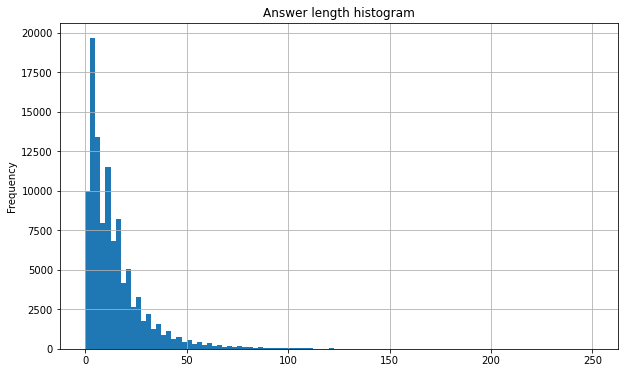

In [ ]:
figsize = (10,6)
train_df['answer'].apply(len).plot.hist(title="Answer length histogram", figsize=figsize, grid=True, range=[0,250], bins = 100);

We can see that most answers are quite short, with most being only a couple of characters long.

## [Task 2] Train, Validation and Test splits

CoQA only provides a train and validation set since the test set is hidden for evaluation purposes.

We'll consider the provided validation set as a test set. <br>
$\rightarrow$ Write your own script to:
* Split the train data in train and validation splits (80% train and 20% val)
* Perform splits such that a dialogue appears in one split only! (i.e., split at dialogue level)
* Perform splitting using the following seed for reproducibility: 42

### Reproducibility
Since we are using both TF and Pytorch components in this notebook we have to make sure that the behaviour of both of these frameworks is reproducible.

In [ ]:
def set_reproducibility(seed:int) -> None: 
  random.seed(seed)
  np.random.seed(seed)

  # Tensorflow
  tf.random.set_seed(seed)
  os.environ['TF_DETERMINISTIC_OPS'] = '1'
  
  # Pytorch
  torch.use_deterministic_algorithms(True)
  torch.manual_seed(seed)

### Data splitting
We want to split at the dialogue level, so we select 80% of dialogues to be part of the train and 20% of the validation set.  
From these we will later obtain QA pairs.

In [ ]:
set_reproducibility(42)

train_split = 0.8

# We obtain a train-val split by first shuffling the indexes of the dialogues
n_dialogues = len(train_data["data"])
dialogue_idxs = np.arange(n_dialogues)
np.random.shuffle(dialogue_idxs)

# And splitting the shuffled indexes
train_ids, val_ids = np.split(dialogue_idxs, [int(len(dialogue_idxs)*train_split)])

# Build train-val sets as a list of dialogues
train_dialogues = []
for idx in train_ids:
    train_dialogues.append(train_data["data"][idx]) # We don't care about the version field in the original dict

val_dialogues = []
for idx in val_ids:
    val_dialogues.append(train_data["data"][idx])

test_dialogues = test_data["data"]
random.shuffle(test_dialogues)

Altough we split by dialogue, our models will receive the QA pairs inside those dialogues as training samples.  
Since we are not sure that the dialogue-level split ratio is the same as the QA-level split ratio when separating dialogues into QA pairs we could have train-validation imbalance.  
Let's check this.

In [ ]:
n_questions_train = sum([len(diag["questions"]) for diag in train_dialogues])
n_questions_val = sum([len(diag["questions"]) for diag in val_dialogues])
n_questions_test = sum([len(diag["questions"]) for diag in test_dialogues])

print(f"Expected question split: train={train_split:.3}, val={1-train_split:.3}")
print(f"Actual question split: train={n_questions_train/(n_questions_train+n_questions_val):.3}, val={n_questions_val/(n_questions_train+n_questions_val):.3}")

Expected question split: train=0.8, val=0.2
Actual question split: train=0.799, val=0.201


It turns out that by splitting 80/20 at the dialogue level we still get around an 80/20 split for the QA pairs as well, no problem here. 

### Dataset creation
We split by dialogue, however our models have to receive individual QA samples with an additional story/history.  We decided to build such a dataset as a pandas DataFrame with the columns:
- **source**, the source from which the dialogue comes
- **context**, the first part of what the model receives in input, either the story or the story plus the past QA history
- **question**, the second part of the model input
- **answer**, what the model has to predict


If our model only received raw text in the form of:  ` concat("story","question") `  
It might have difficulties in identifying where the question (or previous questions in the case of the model which also uses question history) are.  
For this reason we decided to add some delineators to our inputs to denote:
- The start of the story ("STORY:")
- The start of the main question ("QUESTION:")
- The start of the previous questions ("CONTEXT QUESTION") and their answers ("CONTEXT ANSWER")


In [ ]:
# Define the special "tokens" which identify start of story, questions, answers
special_tokens = {"story_start":"STORY",
                  "question_start":"QUESTION:",
                  "history_question_start":"CONTEXT QUESTION:",
                  "history_answer_start":"CONTEXT ANSWER:"}

In [ ]:
# Create an actual dataset to feed into our model, according to our task
def create_dataset_from_diag(dialogues : List[Dict], include_history : bool = False, max_length : int = None) -> pd.DataFrame:
  dataset = []
  for diag in dialogues:
    story = diag["story"]
    context = story
    for i, q in enumerate(diag["questions"]):
      new_row = {
          "source": diag["source"],
          "context":context,
          "question": q["input_text"],
          "answer": diag["answers"][i]["input_text"],
      }
      if include_history:
        # Accumulate the context as the previous QA pairs
        context += special_tokens["history_question_start"] + q["input_text"] +  special_tokens["history_answer_start"] + diag["answers"][i]["input_text"]
      dataset.append(new_row)

      if not max_length is None and len(dataset) >= max_length:
        return pd.DataFrame(dataset)
  
  return pd.DataFrame(dataset)

When creating the datasets to feed into our models we only consider a small subset of the original dataset for computational reasons.

In [ ]:
# Roberta settings, train on 10k samples, test on 1k
"""
train_max_length = 10000
test_max_length = 1000
"""
# Bert-Tiny settings, train on all samples, test on 1k

train_max_length = None
test_max_length = 1000


# Create the datasets with no previous question data
train_df_nohistory = create_dataset_from_diag(train_dialogues, max_length=train_max_length)
val_df_nohistory = create_dataset_from_diag(val_dialogues, max_length=test_max_length)
test_df_nohistory = create_dataset_from_diag(test_dialogues, max_length = test_max_length)

# Create the datasets with previous question data
train_df_history = create_dataset_from_diag(train_dialogues, include_history=True, max_length=train_max_length)
val_df_history = create_dataset_from_diag(val_dialogues, include_history=True, max_length=test_max_length)
test_df_history = create_dataset_from_diag(test_dialogues, include_history=True, max_length=test_max_length)

## [Task 3] Model definition

Write your own script to define the following transformer-based models from [huggingface](https://HuggingFace.co/).

* [M1] DistilRoBERTa (distilberta-base)
* [M2] BERTTiny (bert-tiny)


We decided to initially test 2 types of encoder-decoder models, the first one using a transformer model as the encoder and a RNN as decoder.  
The second one makes use of the EncoderDecoder class from huggingface and uses two of the same type of models both as encoder and decoder.  
After testing the first model (results not included in this notebook) it turns out it wasn't able to output even remotely intelligible answers unless it was trained extensively.

##[Task 3.1] Transformer as encoder and RNN as decoder 

In [ ]:
import keras 
from transformers import AutoTokenizer, TFAutoModel
from tensorflow.keras import layers

def create_model(checkpoint : str, encoder_trainable : bool = False) -> Tuple[keras.Model, AutoTokenizer]:
  # Encoder
  encoder = TFAutoModel.from_pretrained(checkpoint, from_pt=True)
  tokenizer = AutoTokenizer.from_pretrained(checkpoint)
  max_len = tokenizer.model_max_length

  # Freeze (or not) the encoder
  encoder.trainable = encoder_trainable

  # Decoder
  biGRU = layers.Bidirectional(layers.GRU(256, return_sequences=True))

  embed_map = layers.TimeDistributed(layers.Dense(len(tokenizer)))

  # Define model
  # Input 
  input_ids = tf.keras.layers.Input(
      shape=(max_len,), dtype=tf.int32, name="input_ids"
  )
  attention_masks = tf.keras.layers.Input(
      shape=(max_len,), dtype=tf.int32, name="attention_masks"
  )

  # Encode and decode
  x = encoder([input_ids, attention_masks])
  decoder_out = embed_map(biGRU(x["last_hidden_state"]))
  outputs = layers.Softmax()(decoder_out)
  model = keras.Model(inputs=[input_ids, attention_masks], outputs=outputs)

  return model, tokenizer

model_rnn, tokenizer_rnn = create_model("distilroberta-base")
model_rnn.summary()

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 512)]        0           []                               
                                                                                                  
 attention_masks (InputLayer)   [(None, 512)]        0           []                               
                                                                                                  
 tf_roberta_model_1 (TFRobertaM  TFBaseModelOutputWi  82118400   ['input_ids[0][0]',              
 odel)                          thPoolingAndCrossAt               'attention_masks[0][0]']        
                                tentions(last_hidde                                               
                                n_state=(None, 512,                                           

Training code for the Transformer encoder + RNN

In [ ]:
# Using keras and LSTM as decoder
def tokenize_function(sample : Dict, tok : AutoTokenizer) -> Dict:
    raw_input =  special_tokens["question_start"] + sample["question"] + special_tokens["story_start"] + sample["context"]
    input = tok(
        raw_input, truncation=True, padding="max_length"
    )

    raw_target = sample["answer"] 
    target = tok(
        raw_target, truncation=True, padding="max_length"
    )
    return {"input_ids":input["input_ids"], "input_mask": input["attention_mask"], "target":target["input_ids"]}
  

def tokenize_dataset(og_dataset : pd.DataFrame, tokenizer : AutoTokenizer) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
  rows = []
  for i, el in train_df_nohistory.iterrows():
    rows.append(tokenize_function(el, tokenizer))
  tokenized_df = pd.DataFrame(rows)
  del rows

  # Keras works more easily with numpy arrays than dataframes
  ds_input_ids= np.asarray(list(tokenized_df["input_ids"]))
  ds_attention_masks = np.asarray(list(tokenized_df["input_mask"]))
  ds_target_ids = np.asarray(list(tokenized_df["target"]))

  return ds_input_ids, ds_attention_masks, ds_target_ids


def train_model(model : keras.Model, tokenizer : AutoTokenizer, train_ds : pd.DataFrame, val_ds : pd.DataFrame, n_epochs : int = 3, lr : float = 2e-5) -> keras.Model:
  # Tokenize the datasets
  train_input_ids, train_masks, train_y = tokenize_dataset(train_ds, tokenizer)
  val_input_ids, val_masks, val_y = tokenize_dataset(train_ds, tokenizer)

  model.compile(
      loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
      optimizer=keras.optimizers.Adam(learning_rate=lr),

      metrics=["accuracy"],
  )
  model.fit([train_input_ids, train_masks], train_y , batch_size=8, epochs=n_epochs, shuffle=True, validation_data=([val_input_ids, val_masks], val_y))

  return model

trained_rnn = train_model(model_rnn, tokenizer_rnn, train_df_nohistory, val_df_nohistory)


Epoch 1/3
1250/1250 [==============================] - 1114s 887ms/step - loss: 2.1640 - accuracy: 0.9703 - val_loss: 0.1201 - val_accuracy: 0.9909
Epoch 2/3
1250/1250 [==============================] - 1083s 867ms/step - loss: 0.1003 - accuracy: 0.9909 - val_loss: 0.0883 - val_accuracy: 0.9909
Epoch 3/3
1250/1250 [==============================] - 1082s 866ms/step - loss: 0.0837 - accuracy: 0.9909 - val_loss: 0.0792 - val_accuracy: 0.9909


Testing the model on a training set sample

In [ ]:
# Testing on an element from the train set
train_sample_tokenized = tokenize_function(train_df_nohistory.iloc[0], tokenizer_rnn)
out_train_sample = trained_rnn.predict([np.expand_dims(np.asarray(train_sample_tokenized["input_ids"]),0),
                                        np.expand_dims(np.asarray(train_sample_tokenized["input_mask"]), 0)])

# Construct predicted answer by sampling (argmax/greedy just gives back padding)
out = []
for i in range(out_train_sample.shape[1]):
  cur_distribution = out_train_sample[0,i,:]
  choice = np.random.choice(np.arange(0, out_train_sample.shape[-1]), p=cur_distribution)
  out.append(choice)

print("Predicted answer:",tokenizer_rnn.decode(out, skip_special_tokens=True))
print("Real answer:", tokenizer_rnn.decode(train_sample_tokenized["target"], skip_special_tokens=True))

1/1 [==============================] - 0s 86ms/step
Predicted answer:  might Holl RenGROUND foreš
Real answer: the team from Liverpool


##[Task 3.2] Transformer both as encoder and decoder
The second type of model we tried is an encoder-decoder model where both the encoder and the decoder are transformer-based.  
Such a model is created using the `EncoderDecoder` class provided in the transformers library.  

A decision that had to be taken is whether to finetune:
- the entire encoder-decoder network
- only the decoder, by keeping the encoder frozen
- only the decoder head, by keeping the encoder and most of the decoder frozen

In the end we went for the first option, despite its larger computational cost.

In [ ]:
from transformers import EncoderDecoderModel, AutoTokenizer, AutoConfig

def create_model(checkpoint : str, encoder_trainable : bool = False):
  # Here we could add the tokens we used to denote Story/Question start to the tokenizer, however it turned out not to matter much
  tokenizer = AutoTokenizer.from_pretrained(checkpoint, model_max_length=512)
  encoder_decoder = EncoderDecoderModel.from_encoder_decoder_pretrained(checkpoint, checkpoint)

  # Necessary both for generation and training
  if tokenizer.bos_token_id is None: 
    encoder_decoder.config.decoder_start_token_id = tokenizer.cls_token_id
  else:
    encoder_decoder.config.decoder_start_token_id = tokenizer.bos_token_id

  encoder_decoder.config.pad_token_id = tokenizer.pad_token_id
  encoder_decoder.config.eos_token_id = tokenizer.sep_token_id

  if not encoder_trainable:
    for param in encoder_decoder.encoder.parameters():
        param.requires_grad = False

  return encoder_decoder, tokenizer

Instantiate the 2 required models

In [ ]:
# Model 1
def create_model1():
  return create_model("distilroberta-base", encoder_trainable=True)

model1, tokenizer1 = create_model1()
print(model1)
del model1
del tokenizer1

EncoderDecoderModel(
  (encoder): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNo

In [ ]:
# Model 2
def create_model2():
  return create_model("prajjwal1/bert-tiny", encoder_trainable=True)
model2, tokenizer2 = create_model2()
print(model2)
del model2
del tokenizer2

Downloading:   0%|          | 0.00/285 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/17.8M [00:00<?, ?B/s]

EncoderDecoderModel(
  (encoder): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 128)
      (token_type_embeddings): Embedding(2, 128)
      (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=128, out_features=128, bias=True)
              (key): Linear(in_features=128, out_features=128, bias=True)
              (value): Linear(in_features=128, out_features=128, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=128, out_features=128, bias=True)
              (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_af

## [Task 4] Question generation with text passage $P$ and question $Q$

We want to define $f_\theta(P, Q)$. 

We write a script to implement $f_\theta$ for each model: M1 and M2.

#### Formulation

Consider a dialogue on text passage $P$. 

For each question $Q_i$ at dialogue turn $i$, your model should take $P$ and $Q_i$ and generate $A_i$.  

Due to our choice of adding extra special tokens to aid the model in differentiating the question from the answer we have to add them as well.

This function defines how the models should behave when presented with a new Story+Question pair, however it won't be used during training and evaluation where we have the ground truth and the data is formatted into a more convenient/already tokenized way.

In [ ]:
def qa_nohistory(model : EncoderDecoderModel, tokenizer : AutoTokenizer, story : str, question: str, device : str = "cuda"):
  # Define the input to our model as Story+Question
  inputs = tokenizer(special_tokens["question_start"] + question + special_tokens["story_start"] + story , truncation=True, return_tensors="pt").to(device)
  
  # Generate answer (using multinomial sapling without beam search)
  generation_output = model.generate(inputs["input_ids"], num_beams=1, do_sample=True, max_length=100, early_stopping=True)
  return tokenizer.decode(generation_output[0], skip_special_tokens=True)

# Test on the first sample of the train set (when the model is not trained)

test_idx = 0
context = train_df_nohistory.iloc[test_idx]["context"]
question = train_df_nohistory.iloc[test_idx]["question"]
out = qa_nohistory(model1, tokenizer1, context, train_df_nohistory.iloc[0]["question"], device="cpu")
print("Story:")
print(context)
print("Question:")
print(question)
print("Answer")
print(out)


Story:
(CNN) -- Andy Carroll scored twice, his first goals for Liverpool, to help his club comfortably defeat Manchester City 3-0 in Monday's Premier League encounter at Anfield. 

City, who needed a victory to move above Chelsea into third place in the table, were blown away by a devastating first half performance from Liverpool, who have consolidated sixth position with this result. 

Liverpool began brightly and nearly took a seventh-minute lead when Luis Suarez's fine strike was tipped onto the post by City's England goalkeeper Joe Hart. 

But the visiting defense was struggling to cope with Liverpool's wave of attacks and the hosts took a deserved lead six minutes later when Carroll's superbly struck left-footed strike, from just outside the area, swerved past Hart for his first goal since joining the club for a British record transfer fee in January. 

Liverpool doubled their lead in the 34th minute when City failed to clear a succession of crosses and blocked shots, the ball eve

## [Task 5] Question generation with text passage $P$, question $Q$ and dialogue history $H$

We want to define $f_\theta(P, Q, H)$. We write a script to implement $f_\theta$ for each model: M1 and M2.

#### Formulation

Consider a dialogue on text passage $P$. 

For each question $Q_i$ at dialogue turn $i$, your model should take $P$, $Q_i$, and $H = \{ Q_0, A_0, \dots, Q_{i-1}, A_{i-1} \}$ to generate $A_i$.

Due to our choice of adding extra special tokens to aid the model in differentiating the question from the answer we have to add them as well.

This function defines how the models should behave when presented with a new Story+Question+History triplet, however it won't be used during training and evaluation where we have the ground truth and the data is formatted into a more convenient/already tokenized way.

In [ ]:
def qa_history(model : EncoderDecoderModel, tokenizer : AutoTokenizer, story : str, history : List[Tuple[str,str]], question: str, device : str = "cuda"):
  # Add the question
  added_token_input = special_tokens["question_start"] + question

  # Build a context with history
  added_token_input += special_tokens["story_start"] + story
  for el in history:
    added_token_input += special_tokens["history_question_start"] + el[0] + special_tokens["history_answer_start"] + el[1]

  # Generate answer (using multinomial sapling without beam search)
  inputs = tokenizer(added_token_input, return_tensors="pt").to(device)
  generation_output = model.generate(inputs["input_ids"], num_beams=1, do_sample=True, max_length=100, early_stopping=True)

  return tokenizer.decode(generation_output[0], skip_special_tokens=True)

## [Task 6] Train and evaluate $f_\theta(P, Q)$ and $f_\theta(P, Q, H)$

Write your own script to train and evaluate your $f_\theta(P, Q)$ and $f_\theta(P, Q, H)$ models.

### Instructions

* Perform multiple train/evaluation seed runs: [42, 2022, 1337].$^1$
* Evaluate your models with the following metrics: SQUAD F1-score.$^2$
* Fine-tune each transformer-based models for **3 epochs**.
* Report evaluation SQUAD F1-score computed on the validation and test sets.

$^1$ Remember what we said about code reproducibility in Tutorial 2!

$^2$ You can use ```allennlp``` python package for a quick implementation of SQUAD F1-score: ```from allennlp_models.rc.tools import squad```. 

### Training Code

In [ ]:
from transformers import DataCollatorForSeq2Seq, Seq2SeqTrainingArguments, Seq2SeqTrainer
from datasets import Dataset

def tokenize_function(sample : pd.DataFrame, tokenizer : AutoTokenizer, inference = False) -> Dict:
  # Tokenize the context for a single sample
  in_context = special_tokens["question_start"] + sample["question"] + special_tokens["story_start"] + sample["context"]
  if inference:
    inputs = tokenizer(in_context, truncation=True, return_tensors="pt", padding="max_length", max_length=512)
  else:
    inputs = tokenizer(in_context, truncation=True, padding="max_length", max_length=512)

  # Tokenize the answer
  in_answer = sample["answer"]
  labels = tokenizer(in_answer, max_length=32, truncation=True, padding="max_length")

  inputs["labels"] = labels["input_ids"]

  # inputs is generated like it is required by Seq2SeqTrainer, i.e. it needs:
  # input_ids, attention_mask, labels
  return inputs

def tokenize_dataset(og_dataset : pd.DataFrame, tokenizer : AutoTokenizer) -> pd.DataFrame:
  rows = []
  for i, el in train_df_nohistory.iterrows():
    rows.append(tokenize_function(el, tokenizer))
  return pd.DataFrame(rows)

def train_model(model : EncoderDecoderModel, tokenizer : AutoTokenizer, train_ds : pd.DataFrame, val_ds : pd.DataFrame, num_epochs : int = 3, lr : float = 2e-5, batch_size : int = 8):
  # Create tokenized datasets from the dataframes in input
  tokenized_train = tokenize_dataset(train_ds, tokenizer)
  tokenized_val = tokenize_dataset(train_ds, tokenizer)

  # Define the training arguments like learning rate, batch_size number of epochs
  training_args = Seq2SeqTrainingArguments(
      learning_rate=lr,
      do_eval=True,
      evaluation_strategy="epoch",
      per_device_train_batch_size=batch_size,
      num_train_epochs=num_epochs,
      output_dir = ".\out",
      eval_accumulation_steps=1,
      full_determinism=True,
      logging_steps=100
  )

  # Our task is a sequence to sequence task where our objective is to predict the 
  # answer, thus we can use Seq2SeqTrainer
  data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model)

  trainer = Seq2SeqTrainer(
      model=model,
      args=training_args,
      train_dataset=Dataset.from_pandas(tokenized_train),
      eval_dataset=Dataset.from_pandas(tokenized_val),
      tokenizer=tokenizer,
      data_collator=data_collator,

  )

  trainer.train()
  return model

### Evaluation code

In [ ]:
# Define a function to compute the f1 squad score
from evaluate import load

def compute_squad_score(predictions : List[str], ys : List[str], metric = None):
  if not metric is None and len(predictions) == 1 and len(ys) == 1:
    prediction = {'prediction_text': predictions[0], 'id': '0'}
    reference = {'answers': {'answer_start': [0], 'text': [ys[0]]}, 'id': '0'}
    return metric.compute(predictions=[prediction], references=[reference])
    
  squad_metric = load("squad")

  for i in range(len(predictions)):
    # Format it like Huggingface wants it
    prediction = {'prediction_text': predictions[i], 'id': str(i)}
    reference = {'answers': {'answer_start': [0], 'text': [ys[i]]}, 'id': str(i)}

    squad_metric.add(predictions=prediction, references=reference)

  return squad_metric.compute()


In [ ]:
def test_model_on_set(model : EncoderDecoderModel, tokenizer : AutoTokenizer, in_set : pd.DataFrame, device : str = "cuda", print_sample_answers : bool = True):

  model.eval()
  import time
  preds = []
  answers = []
  # Run inference on individual samples
  for idx, sample in in_set.iterrows():
    # Obtain context+question and generate from it
    data_in =  special_tokens["question_start"] + sample["question"]  + special_tokens["story_start"] + sample["context"]
    tokenized_in = tokenizer(data_in, truncation=True, return_tensors="pt").to(device)

    generation_output = model.generate(tokenized_in["input_ids"], num_beams=1, do_sample=True, max_length=100, early_stopping=True)
    pred_answer = tokenizer.decode(generation_output[0], skip_special_tokens=True)

    # Obtain the true answer
    answers.append(sample["answer"])
    preds.append(pred_answer)
  if print_sample_answers:
    print("Some answers:\n", preds[:20])
  return compute_squad_score(preds, answers)["f1"]

### Training and evaluating our models

In [ ]:
run_seeds = [42, 1337, 2022]

In [ ]:
# Model 1 - Roberta, no history
for seed in run_seeds:
  set_reproducibility(seed)
  
  if device == "cuda":
    torch.cuda.empty_cache()
  
  print("Seed for this run:", seed)
  
  # Re-instantiate the model to start training from the initial weights
  model1, tokenizer1 = create_model1() 

  trained_model = train_model(model1, tokenizer1, train_df_nohistory, val_df_nohistory, 3, batch_size=8)
  # Compute val and test scores
  print(f"F1 squad score on validation set: {test_model_on_set(trained_model, tokenizer1, val_df_nohistory)}")
  print(f"F1 squad score on test set: {test_model_on_set(trained_model, tokenizer1, test_df_nohistory)}")
  
  # Free up memory
  del model1
  del trained_model
  print("-"*20)

Seed for this run: 42


Epoch,Training Loss,Validation Loss
1,0.852600,0.805676
2,0.739600,0.708974
3,0.720100,0.659123


Some answers:
 ['The Himal Himal Himal Himalad', '1789', 'The the Ancient Ancient Empire', 'yes', '15th November', 'about 4 October', 'Mujma Kingdom', 'the Greek Greek', 'Yes', 'No', 'The mainland', 'a monk', 'Cortatet', 'The Syrian-No', 'Hindu', 'By the Egypt', 'Yes,', 'Hinduindu', 'Yes', 'a native native languages']


F1 squad score on validation set: 9.252358834022445
Some answers:
 ['a bird', 'into the the home', 'no', 'The salesman', 'Coding', 'No', 'he picked him to new clothes on them', 'she gave her mom', 'No', 'in the village', 'His bed', 'no', 'Tom', 'his grandfather', "Tom'", 'No.', 'Yes', 'It still a fish', 'No.', 'a cat.']
F1 squad score on test set: 11.521479786123756
--------------------
Seed for this run: 1337


Epoch,Training Loss,Validation Loss
1,0.854700,0.812529
2,0.737000,0.710035
3,0.732200,0.674249


Some answers:
 ['The Bengalria, Province and Asia', 'the 15th centuries', 'Cuastas', 'yes', 'two', 'about 60', 'India', 'Gibir', 'yes', 'Yes', '18th centuries', 'West Asia', 'Cugu.', 'yes', 'The city of east of Egypt', 'Canada', 'in the Asia east province,', 'Hataria', 'the British king', 'no']
F1 squad score on validation set: 10.777347742917005
Some answers:
 ['the car and shoes', 'at his bed', 'Yes.', 'Bill', 'a violin', 'Yes', "he was't made his wife,", 'Michael', 'because she was to a dog', 'It had a house', 'Puddenny', 'no', 'Hugi', 'a body.', 'Jaint.', 'Yes', 'no', 'Fopy', 'No', 'a friend']
F1 squad score on test set: 11.727784058047217
--------------------
Seed for this run: 2022


Epoch,Training Loss,Validation Loss
1,0.840000,0.780536
2,0.685200,0.638396
3,0.667800,0.594189


Some answers:
 ['The Himal Himal Himal Himal Himal Himal', 'the 15th centuries', 'Caucasian', 'yes', '1.7,511', '10 kilometers billion, billion', 'the Polish Church', 'The Confederations and the Gulf of Europe', 'no', 'no', '15th centuries', 'The Metropolitan of Central Asia', 'Uuuuuanda', 'Nepuan and U. of U Uta U of China, U..SS., Djiangpei.', 'By sixteenth century', 'King', 'Established Tokyo Islands-Egypt,', 'Nastastat', 'Gangiangkol', 'no']
F1 squad score on validation set: 10.80728178139943
Some answers:
 ['yellow', 'the home', 'no', "The daughter's mom, and girl", 'A bird', 'yes', 'he was little', 'Seedeed', 'a car', 'the pond', 'sunk', 'Yes.', 'Balart', 'She died', 'a party', 'no', 'No', 'smudge', 'Yes', 'Seart']
F1 squad score on test set: 11.092081427344588
--------------------


In [ ]:
# Model 1 - Roberta, history 
for seed in run_seeds:
  if device == "cuda":
    torch.cuda.empty_cache()
    
  set_reproducibility(seed)
  print("Seed for this run:", seed)
  
  # Re-instantiate the model to start training from the initial weights
  model1, tokenizer1 = create_model1()

  trained_model = train_model(model1, tokenizer1, train_df_history, val_df_history, batch_size=8)
  # Compute val and test scores
  print(f"F1 squad score on validation set: {test_model_on_set(trained_model, tokenizer1, val_df_history)}")
  print(f"F1 squad score on test set: {test_model_on_set(trained_model, tokenizer1, test_df_history)}")
  
  # Free up memory
  del model1
  del trained_model
  print("-"*20)

Seed for this run: 42


Epoch,Training Loss,Validation Loss
1,0.852600,0.805676
2,0.739600,0.708974
3,0.720100,0.659123


Some answers:
 ['The Himal Himal Himal Himalad', '1789', 'The the Ancient Ancient Empire', 'yes', 'Portugal', '3,500', 'Hinduindu.', 'Rheyanon', 'a local government', 'yes', '1848', 'a republic', 'Lelandelandburg', 'In the 181953', 'It was to the the the monarch III', 'Hinduia', 'Yes', 'Bbbbibibabber,', 'Janyan', 'it was in the U U.S.U.S.SS..SP.SSSS.S..S']


F1 squad score on validation set: 4.317683868419163
Some answers:
 ['the park', "Cillill's window.", 'the lamp', 'Jim', 'Two', 'the town and little', 'Buddudd.', "Bbrick's hat", 'he was up to a night to the day', 'Powolf', 'the land', 'the dock of the top', 'Caintaintaint', 'his bed', 'Hiker', 'no', 'No', 'yes', 'he left to a house', 'A friend']
F1 squad score on test set: 5.53210203539151
--------------------
Seed for this run: 1337


Epoch,Training Loss,Validation Loss
1,0.854700,0.812529
2,0.737000,0.710035
3,0.732200,0.674249


Some answers:
 ['The Bengalria, Province and Asia', 'the 15th centuries', 'Cuastas', 'yes', 'two', 'about 60', 'the Ancient Chinese Empire Kingdom', 'The Crown monarchy', 'Yes', 'No.', 'half more centuries', 'a Himalatar', 'Vawas', 'In kilometres', 'Halatly', 'India', 'Yes,', 'Hataria', 'Yes', 'Yes']
F1 squad score on validation set: 8.957735320235322
Some answers:
 ['it was not to it-coat', 'the hotel', 'yes', 'Burt', 'a squirrel', 'yes', 'Mashy', 'A mother', 'for one', 'cook', 'She wants', 'Yes', 'A elephant of the snow', 'He was found the bird', 'Dirora', 'Yes', 'Yes', 'no', 'No', 'Cudinda']
F1 squad score on test set: 11.524868628103922
--------------------
Seed for this run: 2022


Epoch,Training Loss,Validation Loss
1,0.840000,0.780536
2,0.685200,0.638396
3,0.667800,0.594189


Some answers:
 ['The Himal Himal Himal Himal Himal Himal', 'the 15th centuries', 'Caucasian', 'Yes', '1.7,511', '10 kilometers billion, billion', 'the first provinces of Asia', 'Bishop II.', 'yes', 'a city as large region with the other English,', 'In 1657', 'Uu. Siangawiangang,', 'Hindu of Udhisuba', 'the New Persian Empire', 'It had found the first cousin', 'Hinduic and Israel', 'Guese-Palin-Egypt,', 'Nastastat', 'Gangiangkol', 'no']
F1 squad score on validation set: 8.935805207864032
Some answers:
 ['a little little little white', 'the door', 'no', 'Tolissa.', 'A meal', 'A rabbit', 'a bed', 'Pascal', 'They could make and fish', 'A ball', 'tipped it', 'yes', 'Gavato', 'slayers', 'Aime', 'Yes', 'No', 'a white shirt and brown hole', 'Yes', 'Wamam']
F1 squad score on test set: 9.779340659340663
--------------------


In [ ]:
# Model 2 - Bert-tiny, no history
for seed in run_seeds:
  if device == "cuda":
    torch.cuda.empty_cache()
    
  set_reproducibility(seed)
  print("Seed for this run:", seed)

  # Re-instantiate the model to start training from the initial weights
  model2, tokenizer2 = create_model2()

  trained_model = train_model(model2, tokenizer2, train_df_nohistory, val_df_nohistory, batch_size=32)
  # Compute val and test scores
  print(f"F1 squad score on validation set: {test_model_on_set(trained_model, tokenizer2, val_df_nohistory)}")
  print(f"F1 squad score on test set: {test_model_on_set(trained_model, tokenizer2, test_df_nohistory)}")
  
  # Free up memory
  del model2
  del trained_model
  print("-"*20)

Seed for this run: 42


Epoch,Training Loss,Validation Loss
1,0.680000,0.631011
2,0.631300,0.593462
3,0.611700,0.585568


Some answers:
 ['the city of the north of jerusalem', 'on the 18th century', 'the ottoman empire', 'no', 'two', '12', 'portuguese', 'english', 'yes', 'yes', 'three', 'paris', 'to an italian city', 'the new kingdom of southern european countries', 'yes', 'russia', 'the united kingdom of the united kingdom', 'san francisco', 'saint louis court of the united states and the united states', 'no']


F1 squad score on validation set: 10.360433407462722
Some answers:
 ['a big fish', 'at the house.', 'yes', 'a man', 'mr', 'yes', 'as he had gotten into him', 'yes', 'a bottle', 'london', "i's", 'yes', 'the first half - haired', "if they's to use the dog", 'the lady was her husband', 'yes', 'no', 'on the door', 'no', 'michael']
F1 squad score on test set: 11.361707592634708
--------------------
Seed for this run: 1337


Epoch,Training Loss,Validation Loss
1,0.681500,0.633987
2,0.628000,0.589520
3,0.608300,0.581581


Some answers:
 ['the city of the north of jerusalem', 'on the 18th century century', 'the country', 'no', 'two', '707', '" the english word " - german or the " region of french', 'national civil war', 'no', 'no', '15, 000 in 200', 'the river region', 'the united kingdom group', 'he had made him against france', 'no', 'egypt', 'from the east of germany.', 'a jewish union', 'china', 'yes']
F1 squad score on validation set: 8.329030238769086
Some answers:
 ['a big turtle', 'at the house.', 'yes', 'grandma', 'two kids', 'she watched with their feet', 'make him as she had been in a room.', 'the house', 'a few more dozen', 'the snow', 'a good girl', 'no?', 'mr..', 'in the sun', 'he was the captain', 'no', 'yes', 'on the sofa', 'he was sure', 'lady']
F1 squad score on test set: 12.530636548232463
--------------------
Seed for this run: 2022


Epoch,Training Loss,Validation Loss
1,0.679300,0.631828
2,0.629800,0.591029
3,0.609700,0.582896


Some answers:
 ['the city of the north of jerusalem', 'the french - german', 'france and east', 'no', 'two', '707', '" the italian word " - german or the polish region of french', 'the united kingdom.', 'yes', 'yes', 'five', 'south africa', 'the indian region', 'in the north african island', 'yes', 'france', 'the united states', 'france and france and the netherlands.', 'a grand grand prix', 'yes']
F1 squad score on validation set: 9.483989127676036
Some answers:
 ['yes', 'no', 'no', 'sam', 'hot.', 'yes', 'yes', 'the first room', "his mom didn't go", 'new hampshire', 'she watched an hour', 'yes', 'a tree', 'when they were made to get the house', 'steve', 'yes', 'yes', 'a long distance', 'no', 'to the town']
F1 squad score on test set: 11.745321750533765
--------------------


In [ ]:
# Model 2 - Bert-tiny, history
for seed in run_seeds:
  if device == "cuda":
    torch.cuda.empty_cache()
    
  set_reproducibility(seed)
  print("Seed for this run:", seed)

  # Re-instantiate the model to start training from the initial weights
  model2, tokenizer2 = create_model2()
  trained_model = train_model(model2, tokenizer2, train_df_history, val_df_history, batch_size=32)
  # Compute val and test scores
  print(f"F1 squad score on validation set: {test_model_on_set(trained_model, tokenizer2, val_df_history)}")
  print(f"F1 squad score on test set: {test_model_on_set(trained_model, tokenizer2, test_df_history)}")
  
  # Free up memory
  del model2
  del trained_model
  print("-"*20)

Seed for this run: 42


Epoch,Training Loss,Validation Loss
1,0.680000,0.631011
2,0.631300,0.593462
3,0.611700,0.585568


Some answers:
 ['the city of the north of jerusalem', 'on the 18th century', 'the world war', 'no', 'two', '12', 'portuguese', 'english', 'yes', 'yes', 'three', 'paris', 'to an italian city', 'the new kingdom of southern european countries', 'yes', 'russia', 'the united kingdom of the united kingdom', 'san francisco', 'saint louis court of the first apostolic and the byzantine monarchy', 'no']


F1 squad score on validation set: 9.585725086460384
Some answers:
 ['the day is pretty nice', 'her family', 'no', 'fred had gone', 'a bear was a giant tiger', 'no', 'a little little dog', 'his father', 'he got something to make things', 'the last last weekend.', 'the way.', 'yes, no', 'the man.', 'to come in a rock', 'she saw the dog', 'no', 'no', 'the river', 'yes', 'he is so nice']
F1 squad score on test set: 11.499988601869413
--------------------
Seed for this run: 1337


Epoch,Training Loss,Validation Loss
1,0.681500,0.633987
2,0.628000,0.589520
3,0.608300,0.581581


Some answers:
 ['the city of the north of jerusalem', 'on the 18th century century', 'the country', 'no', 'two', '707', '" the english word " - german or the " region of french', 'national government of islamic jihad', 'yes', 'no', 'five years when they would 1 million', 'china', 'the north african.', 'that was almost the beginning on the state of the first population from the east of nepal.', 'yes', 'france and eastern ireland', 'a small part', 'the war war war', 'the first governor of the government', 'yes']
F1 squad score on validation set: 10.228338922047321
Some answers:
 ['with the ice cream cream', 'no', 'no', 'helen', 'yes', 'no', 'three days', 'the snow and snow', 'she had done', 'the woods', "he made a game that i didn't be hurt about the snow", 'yes', 'john', 'a big boy with one - year class with a puppy', 'sir', 'yes.', 'yes', 'a long long tree', 'no', 'a little man']
F1 squad score on test set: 12.948243408339323
--------------------
Seed for this run: 2022


Epoch,Training Loss,Validation Loss
1,0.679300,0.631828
2,0.629800,0.591029
3,0.609700,0.582896


Some answers:
 ['the city of the north of jerusalem', 'the french - german', 'france and east', 'no', 'two', '707', '" the italian word " - german or the " region of french', 'the united kingdom.', 'yes', 'yes', 'five', 'south africa', 'the indian region', 'in the north african.', 'yes', 'france', 'the united states', 'he was a part of his most most powerful human war war', 'china', 'no']
F1 squad score on validation set: 10.930840500789357
Some answers:
 ['the water', 'a tree', 'yes', 'james or the first horse', 'it can be made on the wall.', 'yes', 'because he was an old', 'mr. the stone', 'yes', 'from an open chair', 'the table', 'no', 'because he was scared', 'she was wet,', 'john,', 'yes', 'yes', 'he looked the great stones', 'when they were not not alive for her.', 'no']
F1 squad score on test set: 12.511219822755805
--------------------


To recap, these were the results:  
Validation


| Model                  | Seed 42 | Seed 1337 | Seed 2022 |
|------------------------|---------|-----------|-----------|
| roberta - No history   |   9.252      | 10.777           |       10.807    |
| roberta - History      |     4.317    |   8.957        |     8.935      |
| bert-tiny - No History |    10.360     |     8.329      |   9.484        |
| bert-tiny - History    |   9.585      |    10.228       |   10.931        |

Test

| Model                  | Seed 42 | Seed 1337 | Seed 2022 |
|------------------------|---------|-----------|-----------|
| roberta - No history   |    11.521     |  11.727         |     11.092      |
| roberta - History      |    5.532     | 11.524          | 9.779          |
| bert-tiny - No History |    11.362     |   12.531        |    11.745       |
| bert-tiny - History    |   11.499      |   12.948        |   12.511        |


## [Task 7] Error Analysis

Perform a simple and short error analysis as follows:
* Group dialogues by ```source``` and report the worst 5 model errors for each source (w.r.t. SQUAD F1-score).
* Inspect observed results and try to provide some comments (e.g., do the models make errors when faced with a particular question type?)$^1$

$^1$ Check the [paper](https://arxiv.org/pdf/1808.07042.pdf) for some valuable information about question/answer types (e.g., Table 6, Table 8) 

-----------------------------------------

To prevent having to retrain too many times and since we noticed that the removal/addition of the conversational history does not influence the performance of our models too much we decided to perform error analysis on two different models, based respectively on roberta and bert-tiny, trained with history.  

Since showing only the worst results would not let us appreciate when our models work, we decided to also show the best results.

Here we display the 5 worst and best question-answer pairs grouped by source for these two models:

In [ ]:
def get_best_worst_by_source(model : EncoderDecoderModel, tokenizer : AutoTokenizer, dataframe : pd.DataFrame, n_top_bottom : int = 5):
  squad_metric = load("squad")

  result_by_source = {}
  # Split test set by source
  for groupname, group in dataframe.groupby("source"):
    # Evaluate individual sources 
    result_by_source[groupname] = {"topX":[],"bottomX":[]}
    for i,sample in group.iterrows(): 
      # Since our dataframe has already incorporated history information inside of it we can use
      # f_\Theta(P,Q) to get a prediction
      preds = [qa_nohistory(model, tokenizer, sample["context"], sample["question"])]
      ys = [sample["answer"]]
      # Get SQUAD F1 score
      f1_score = compute_squad_score(preds, ys, metric=squad_metric)["f1"]
      # Obtain top5 worst and best results for each of them

      # TOP
      if len(result_by_source[groupname]["topX"])< n_top_bottom:
        result_by_source[groupname]["topX"].append((f1_score, sample, preds[0]))
      else:
        # Find the worst sample and if the current sample is better than it replace it
        argmin =  np.argmin([el[0] for el in result_by_source[groupname]["topX"]])
        if result_by_source[groupname]["topX"][argmin][0] < f1_score:
          result_by_source[groupname]["topX"][argmin] = (f1_score, sample, preds[0])

      # BOTTOM
      if len(result_by_source[groupname]["bottomX"])< n_top_bottom:
        result_by_source[groupname]["bottomX"].append((f1_score, sample, preds[0]))
      else:
        # Find the best sample and if the current sample is better than it replace it
        argmax =  np.argmax([el[0] for el in result_by_source[groupname]["bottomX"]])
        if result_by_source[groupname]["bottomX"][argmax][0] > f1_score:
          result_by_source[groupname]["bottomX"][argmax] = (f1_score, sample, preds[0])
    # Re-sort it
    result_by_source[groupname]["topX"] = sorted(result_by_source[groupname]["topX"], key=lambda x: x[0], reverse=True)
    result_by_source[groupname]["bottomX"] = sorted(result_by_source[groupname]["bottomX"], key=lambda x: x[0])

  return result_by_source

###  Error analysis on Roberta

In [ ]:
set_reproducibility(10)

# Retrain
model1, tokenizer1 = create_model1()
trained_model = train_model(model1, tokenizer1, train_df_history, val_df_history, batch_size=8)
del model1

test_model = trained_model
test_tokenizer = tokenizer1


# Obtain results
best_worst_results = get_best_worst_by_source(test_model, test_tokenizer, test_df_history)

for source in best_worst_results:
  print("Source:", source)

  print("Best results")
  for res in best_worst_results[source]["topX"]:
    print(f"Context:{res[1]['context'][:100]}...\n\n Question:{res[1]['question']}\n Real answer:{res[1]['answer']}\n Predicted answer:{res[2]}\n F1 score:{res[0]}")
    print("*"*8)

  print("Worst results")
  for res in best_worst_results[source]["bottomX"]:
    print(f"Context:{res[1]['context'][:100]}...\n\n Question:{res[1]['question']}\n Real answer:{res[1]['answer']}\n Predicted answer:{res[2]}\n F1 score:{res[0]}")
    print("*"*8)
  print("-"*15)


Epoch,Training Loss,Validation Loss
1,0.860100,0.814437
2,0.747300,0.721236
3,0.737600,0.676559


Source: cnn
Best results
Context:(The Frisky) -- By T-minus 18 days until the Oscars and, of course, we are all starting to place bet...

 Question:Did she get another one earlier?
 Real answer:Yes.
 Predicted answer:Yes
 F1 score:100.0
********
Context:(CNN) -- A body discovered at Churchill Downs on Sunday, a day after the storied Louisville racetrac...

 Question:Is that a racetrack?
 Real answer:Yes
 Predicted answer:yes
 F1 score:100.0
********
Context:(CNN) -- Evangelist Tony Alamo was arrested Thursday in Flagstaff, Arizona, on charges related to a ...

 Question:Did he resist arrest?
 Real answer:no
 Predicted answer:no
 F1 score:100.0
********
Context:(The Frisky) -- By T-minus 18 days until the Oscars and, of course, we are all starting to place bet...

 Question:Can a true story moive produce best performers?
 Real answer:Yes.
 Predicted answer:yes
 F1 score:100.0
********
Context:(CNN) -- Russia and South Ossetia have strongly denied news reports that a motorcade carrying t

###  Error analysis on BERT-Tiny

In [ ]:
set_reproducibility(10)

# Retrain
model2, tokenizer2 = create_model2()
trained_model = train_model(model2, tokenizer2, train_df_history, val_df_history, batch_size=32)
del model2

test_model = trained_model
test_tokenizer = tokenizer2
# Obtain results

best_worst_results = get_best_worst_by_source(test_model, test_tokenizer, test_df_history)

for source in best_worst_results:
  print("Source:", source)

  print("Best results")
  for res in best_worst_results[source]["topX"]:
    print(f"Context:{res[1]['context'][:100]}...\n\n Question:{res[1]['question']}\n Real answer:{res[1]['answer']}\n Predicted answer:{res[2]}\n F1 score:{res[0]}")
    print("*"*8)

  print("Worst results")
  for res in best_worst_results[source]["bottomX"]:
    print(f"Context:{res[1]['context'][:100]}...\n\n Question:{res[1]['question']}\n Real answer:{res[1]['answer']}\n Predicted answer:{res[2]}\n F1 score:{res[0]}")
    print("*"*8)
  print("-"*15)


Epoch,Training Loss,Validation Loss
1,0.679600,0.630923
2,0.627000,0.588601
3,0.608000,0.580849


Source: cnn
Best results
Context:(The Frisky) -- By T-minus 18 days until the Oscars and, of course, we are all starting to place bet...

 Question:Did she get another one earlier?
 Real answer:Yes.
 Predicted answer:yes
 F1 score:100.0
********
Context:(CNN) -- Evangelist Tony Alamo was arrested Thursday in Flagstaff, Arizona, on charges related to a ...

 Question:Does he admit to doing evil acts?
 Real answer:no
 Predicted answer:no
 F1 score:100.0
********
Context:(CNN) -- A body discovered at Churchill Downs on Sunday, a day after the storied Louisville racetrac...

 Question:Is that a racetrack?
 Real answer:Yes
 Predicted answer:yes
 F1 score:100.0
********
Context:(CNN) -- A body discovered at Churchill Downs on Sunday, a day after the storied Louisville racetrac...

 Question:Is the racetrack in operation 24 hours a day?
 Real answer:Yes
 Predicted answer:yes
 F1 score:100.0
********
Context:(CNN) -- A body discovered at Churchill Downs on Sunday, a day after the storied Louis

We can see that both our models are quite dumb and most of the time they get correct answer is when they are "yes/no" answers. This is enough to get it over a 10% F1 score (since in the data inspection part we observed how around 11% of the answers are yes/no answers) but not enough for it to be reliable.

As for more complex answer types, in particular fluency and counting, it looks like the model almost never gets them right.

In the end it turned out that even the most complex model we created (Roberta trained on Story + Question history) was not able to solve this task.  
Some of the most probable reasons for this insuccess are:
- The model does not have enough capacity or the pretraining regime (usually masked language modeling) conflicts with the downstream task of language generation
- Due to our computational constraints the model could only be trained for a small amount of epochs on a restricted dataset
- Story + contexts are quite long and they might get truncated early, thus losing some information which was needed for the question answering

# Appendix : Using a proper model

We've observed unsatisfying results using the previous models, to make sense of them (and be sure that the problem does not lie in the training recipe) let's try to train a model which was pretrained on a seq2seq task, i.e. it's definitely more suited for language generation.  
We shall try to use the "t5-base" model.



In [ ]:
!pip install sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Model creation

In [ ]:
from transformers import T5Tokenizer, T5ForConditionalGeneration
def create_model3():
  tokenizer = T5Tokenizer.from_pretrained('t5-base')
  model = T5ForConditionalGeneration.from_pretrained("t5-base")
  return model, tokenizer

## Dataset creation

In [ ]:
train_df_nohistory = create_dataset_from_diag(train_dialogues, include_history=False, max_length=10000)
val_df_nohistory = create_dataset_from_diag(val_dialogues, include_history=False, max_length=1000)
test_df_nohistory = create_dataset_from_diag(test_dialogues, include_history=False, max_length=1000)

## Training the model

In [ ]:
set_reproducibility(42)

if device == "cuda":
  torch.cuda.empty_cache()

print("Seed for this run:", 42)

# Re-instantiate the model to start training from the initial weights
model3, tokenizer3 = create_model3() 

trained_model = train_model(model3, tokenizer3, train_df_nohistory, val_df_nohistory, 3)

# Compute val and test scores
print(f"F1 squad score on validation set: {test_model_on_set(trained_model, tokenizer3, val_df_nohistory)}")
print(f"F1 squad score on test set: {test_model_on_set(trained_model, tokenizer3, test_df_nohistory)}")

del model3
del trained_model

Seed for this run: 42


Downloading:   0%|          | 0.00/792k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.20k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/892M [00:00<?, ?B/s]

Epoch,Training Loss,Validation Loss
1,0.176100,0.144328
2,0.155700,0.129768
3,0.146600,0.126036


Some answers:
 ['Angkor Wat', '802 AD', 'Kingdom of Cambodia', 'Yes', 'over floor (/1e6) million', 'Vietnamese, Chinese, Chams, and 30 hill tribes.', 'Vietnamese, Chinese, Chams, and 30 hill tribes.', 'Hun Sen', 'True', 'over 30 years', 'over 30 years', 'Southeast Asia', 'France', 'built monumental temples', 'yes', 'Laos', 'the Gulf of Thailand', 'the warring Khmer princes of Chenla', 'The Khmer Empire', 'temples']


F1 squad score on validation set: 56.89055119533397
Some answers:
 ['two', 'October 29', 'about forty years ago', 'two', '21,', 'helped her to communicate with parents.', 'Guangdong University', 'yes', 'her two parents, a younger brother and two younger sisters', 'a professor', 'an aging population and labor shortages', 'They can have the good influence', 'Professor', 'Guangdong University', 'China Daily', 'loneliness, fear and so on', 'Liu Fang', 'Guangdong University', '2-year', 'no']
F1 squad score on test set: 55.0087334486058


SQUAD F1 score results:
- Validation: 56.891
- Test: 55.009


# Assignment Evaluation

The following assignment points will be awarded for each task as follows:

* Task 1, Pre-processing $\rightarrow$ 0.5 points.
* Task 2, Dataset Splitting $\rightarrow$ 0.5 points.
* Task 3 and 4, Models Definition $\rightarrow$ 1.0 points.
* Task 5 and 6, Models Training and Evaluation $\rightarrow$ 2.0 points.
* Task 7, Analysis $\rightarrow$ 1.0 points.
* Report $\rightarrow$ 1.0 points.

**Total** = 6 points <br>

We may award an additional 0.5 points for outstanding submissions. 
 
**Speed Bonus** = 0.5 extra points <br>

# Report

We apply the rules described in Assignment 1 regarding the report.
* Write a clear and concise report following the given overleaf template (**max 2 pages**).
* Report validation and test results in a table.$^1$
* **Avoid reporting** code snippets or copy-paste terminal outputs $\rightarrow$ **Provide a clean schema** of what you want to show

# Comments and Organization

Remember to properly comment your code (it is not necessary to comment each single line) and don't forget to describe your work!

Structure your code for readability and maintenance. If you work with Colab, use sections. 

This allows you to build clean and modular code, as well as easy to read and to debug (notebooks can be quite tricky time to time).